In [9]:
import os
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

from transformers import Wav2Vec2Processor, Wav2Vec2Model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

if torch.cuda.is_available():
    print("GPU utilisé :", torch.cuda.get_device_name(0))


Device: cuda
GPU utilisé : NVIDIA GeForce RTX 4050 Laptop GPU


In [10]:
EMOTION_TO_IDX = {
    "anger": 0,
    "disgust": 1,
    "fear": 2,
    "happy": 3,
    "neutral": 4,
    "sad": 5
}

In [11]:
class SER_RawDataset(torch.utils.data.Dataset):
    def __init__(self, root):
        self.samples = []

        for fname in os.listdir(root):
            if fname.endswith(".wav"):
                full_path = os.path.join(root, fname)

                
                emotion_code = fname.split("_")[2]  

                EMOTION_MAP = {
                    "ANG": 0,
                    "DIS": 1,
                    "FEA": 2,
                    "HAP": 3,
                    "NEU": 4,
                    "SAD": 5
                }

                label = EMOTION_MAP.get(emotion_code)
                if label is not None:
                    self.samples.append((full_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]

        wav, sr = torchaudio.load(path)
        wav = wav.mean(dim=0)  # mono
        wav = torchaudio.functional.resample(wav, sr, 16000)

        return wav, label


dataset = SER_RawDataset("../data/raw/AudioWAV")
print("Total samples:", len(dataset))


Total samples: 7442


In [12]:
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(
    "facebook/wav2vec2-xls-r-300m"
)

w2v2 = Wav2Vec2Model.from_pretrained(
    "facebook/wav2vec2-xls-r-300m",
    use_safetensors=True
).to(device)

w2v2.eval()


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2LayerNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
      (1-4): 4 x Wav2Vec2LayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2LayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=1024, bias=True)
    (dropout)

In [13]:
def extract_embedding(waveform):
    inputs = feature_extractor(
        waveform,
        sampling_rate=16000,
        return_tensors="pt",
        padding=True
    )

    with torch.no_grad():
        outputs = w2v2(inputs.input_values.to(device))
        hidden_states = outputs.last_hidden_state   

    
    emb = hidden_states.mean(dim=1).cpu().numpy()[0]  
    return emb


In [14]:
X = []
y = []

for wav, label in dataset:
    emb = extract_embedding(wav)
    X.append(emb)
    y.append(label)

X = np.array(X)
y = np.array(y)

print("Embeddings shape:", X.shape)


Embeddings shape: (7442, 1024)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [16]:
clf = LinearSVC()
clf.fit(X_train, y_train)


LinearSVC()

In [17]:
preds = clf.predict(X_test)

acc = accuracy_score(y_test, preds)
f1 = f1_score(y_test, preds, average="macro")

print("Accuracy:", acc)
print("F1-score:", f1)


Accuracy: 0.7353928811282741
F1-score: 0.735032971301806


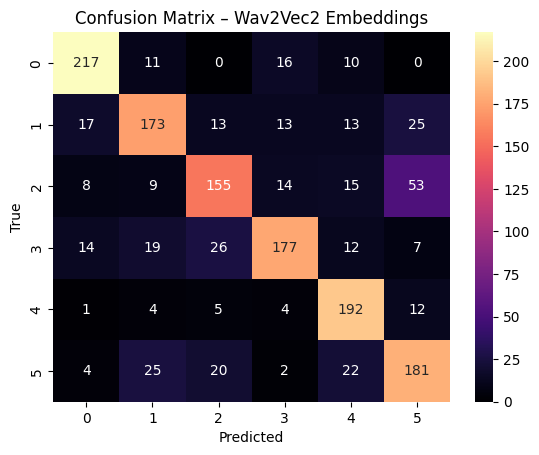

In [18]:
cm = confusion_matrix(y_test, preds)

sns.heatmap(cm, annot=True, fmt="d", cmap="magma")
plt.title("Confusion Matrix – Wav2Vec2 Embeddings")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("figures/confusion_wav2vec2.png", dpi=300, bbox_inches="tight")
plt.show()
